In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pywt import wavedec
import pywt
import numpy as np
import pandas as pd
from scipy.stats import iqr
import sys
import copy
import copy 
from scipy import stats

In [2]:
df = pd.read_pickle('pkl files/a01.pkl')

In [3]:
print(df)

             0
0       -0.060
1       -0.065
2       -0.060
3       -0.075
4       -0.065
...        ...
2956995  0.000
2956996  0.000
2956997  0.000
2956998  0.000
2956999  0.000

[2957000 rows x 1 columns]


In [4]:
dbfile = open('apnea_ecg.pkl', 'rb') 

In [5]:
print(dbfile)

<_io.BufferedReader name='apnea_ecg.pkl'>


In [6]:
import pickle

In [7]:
db = pickle.load(dbfile)

In [8]:
x = []
for k in db:
    lim = len(db[k])
    y = []
    i = 0
    for j in range(lim):
        y.append(db[k][j])
        i=i+1
        if(i%100==0):
            x.append(y)
            y = []

In [9]:
length = len(x)
print(length)

29570


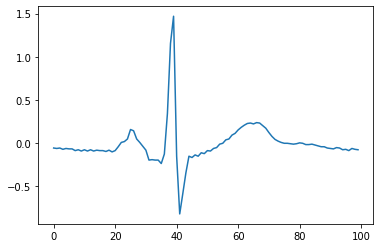

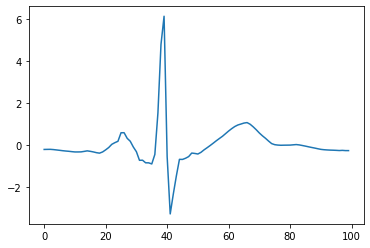

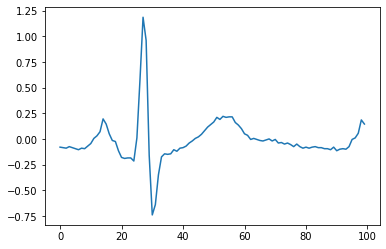

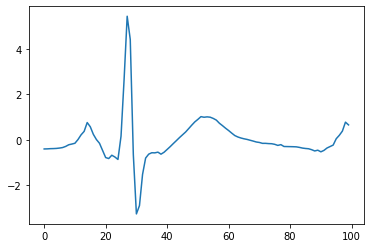

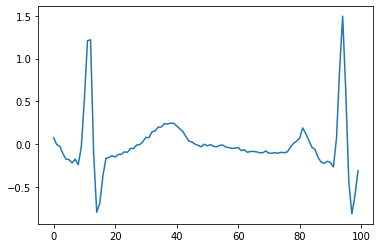

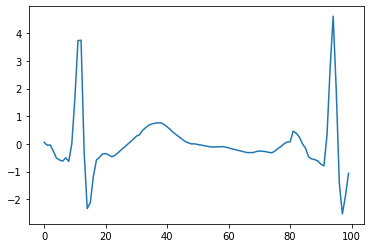

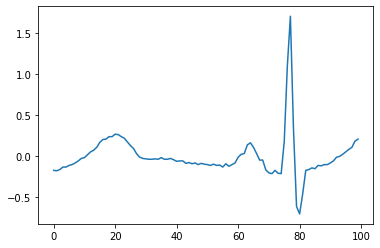

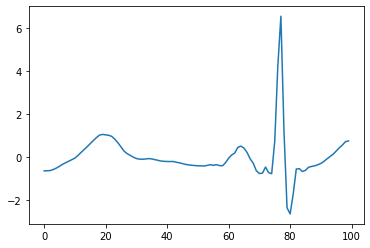

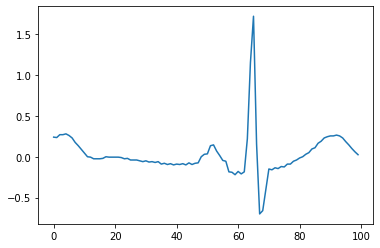

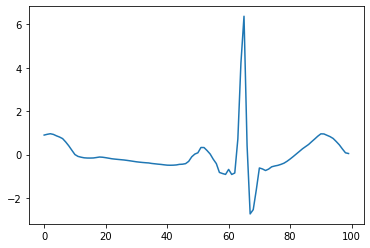

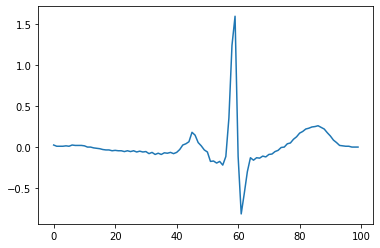

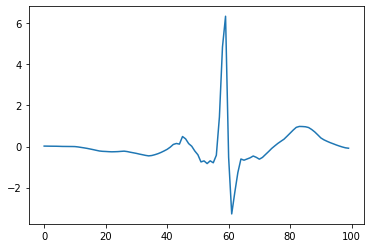

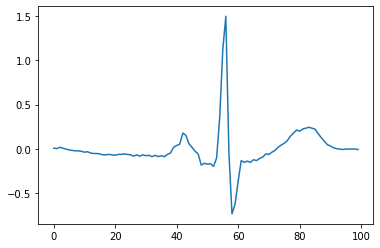

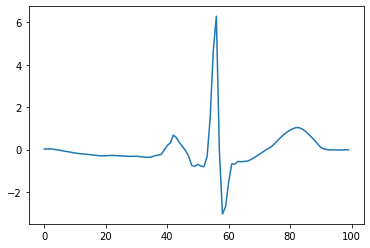

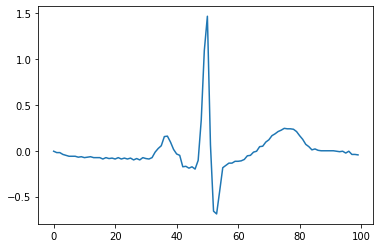

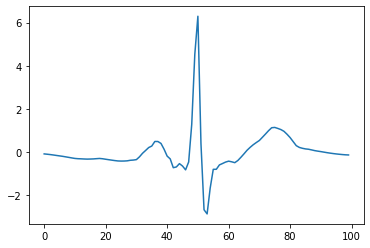

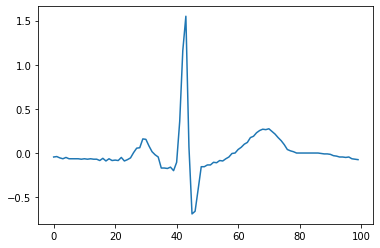

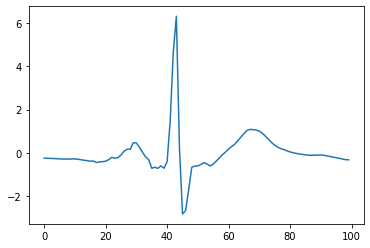

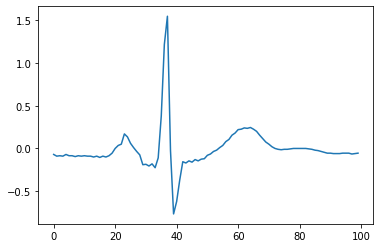

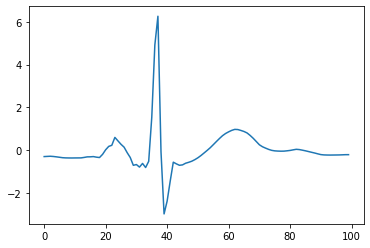

In [10]:
def denoise_normalize(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    signals = stats.zscore(datarec)
    return signals

for i in range(10):
    plt.plot(x[i])
    plt.show()
    x[i] = denoise_normalize(x[i])
    plt.plot(x[i])
    plt.show()
    

    

In [11]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(x, test_size=0.20)
print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (23656, 100)
X_test  :  (5914, 100)


In [12]:
train = np.array(train)
test = np.array(test)
train_x = train.reshape(len(train), train.shape[1],1)
test_x = test.reshape(len(test), test.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(23656, 100, 1) (5914, 100, 1)


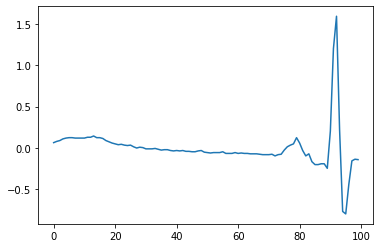

In [13]:
d1 = train_x[1]
plt.plot(d1)
plt.show()


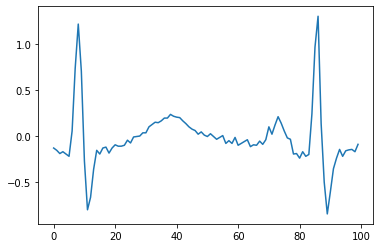

In [14]:
d2 = test_x[0]
plt.plot(d2)
plt.show()

In [15]:
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Conv1DTranspose,BatchNormalization
from tensorflow.keras.models import Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax,LeakyReLU

In [31]:
#encoder part
input_layer = Input(shape=(100,1 ), name="INPUT")
x = Conv1D(8,3, activation='relu', padding='same')(input_layer)
x = MaxPooling1D(2,padding='valid')(x)
x = Conv1D(4,3, activation='relu', padding='same')(x)
x = Conv1D(4,3, activation='relu', padding='same')(x)
x = MaxPooling1D(2,padding='valid')(x)
x = Conv1D(4, 3, activation='relu', padding='same')(x)
x = Conv1D(4,3, activation='relu', padding='same')(x)
x = MaxPooling1D(2,padding='valid')(x)
x = Conv1D(2, 3, activation='relu', padding='same')(x)
x = Conv1D(2, 3, activation='relu', padding='same')(x)
code_layer = MaxPooling1D(2, name="CODE")(x)




In [40]:
#decoder part
x = Conv1D(4,1, activation='relu')(code_layer)
x = UpSampling1D(2)(x)
x = Conv1D(4,3, activation='relu', padding='same')(x)
x = Conv1D(4,3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1D(8,1, activation='relu')(x)
x = Conv1D(8,1, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1D(3,1,activation='relu')(x)
x = Conv1D(3,1,activation='relu')(x)
x = UpSampling1D(2)(x)
output_layer = Conv1D(1, 1, name="OUTPUT")(x)

In [41]:
ae_model = Model(input_layer,output_layer)
ae_model.compile(optimizer='sgd',loss='mse')
ae_model.summary()
ae_model.output_shape

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 100, 1)]          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 100, 8)            32        
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 50, 8)             0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 50, 4)             100       
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 50, 4)             52        
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 25, 4)             0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 25, 4)           

(None, 96, 1)

In [19]:
history = ae_model.fit(train_x, train_x,epochs=500,batch_size=36,shuffle=True,validation_data=(test_x, test_x))

Epoch 1/500
658/658 [==============================] - 5s 7ms/step - loss: 0.0600 - val_loss: 0.0598
Epoch 2/500
658/658 [==============================] - 5s 7ms/step - loss: 0.0600 - val_loss: 0.0597
Epoch 3/500
658/658 [==============================] - 5s 8ms/step - loss: 0.0599 - val_loss: 0.0597
Epoch 4/500
658/658 [==============================] - 6s 9ms/step - loss: 0.0599 - val_loss: 0.0596
Epoch 5/500
658/658 [==============================] - 6s 8ms/step - loss: 0.0599 - val_loss: 0.0596
Epoch 6/500
658/658 [==============================] - 5s 8ms/step - loss: 0.0598 - val_loss: 0.0595
Epoch 7/500
658/658 [==============================] - 5s 8ms/step - loss: 0.0598 - val_loss: 0.0595
Epoch 8/500
658/658 [==============================] - 5s 8ms/step - loss: 0.0597 - val_loss: 0.0594
Epoch 9/500
658/658 [==============================] - 5s 8ms/step - loss: 0.0597 - val_loss: 0.0594
Epoch 10/500
658/658 [==============================] - 5s 8ms/step - loss: 0.0596 - val_lo

Epoch 161/500
658/658 [==============================] - 5s 8ms/step - loss: 0.0562 - val_loss: 0.0559
Epoch 162/500
658/658 [==============================] - 5s 8ms/step - loss: 0.0562 - val_loss: 0.0559
Epoch 163/500
658/658 [==============================] - 5s 8ms/step - loss: 0.0561 - val_loss: 0.0559
Epoch 164/500
658/658 [==============================] - 6s 8ms/step - loss: 0.0561 - val_loss: 0.0559
Epoch 165/500
658/658 [==============================] - 5s 8ms/step - loss: 0.0561 - val_loss: 0.0559
Epoch 166/500
658/658 [==============================] - 6s 8ms/step - loss: 0.0561 - val_loss: 0.0559
Epoch 167/500
658/658 [==============================] - 5s 8ms/step - loss: 0.0561 - val_loss: 0.0558
Epoch 168/500
658/658 [==============================] - 5s 8ms/step - loss: 0.0561 - val_loss: 0.0558
Epoch 169/500
658/658 [==============================] - 5s 8ms/step - loss: 0.0561 - val_loss: 0.0558
Epoch 170/500
658/658 [==============================] - 5s 8ms/step - lo

658/658 [==============================] - 16s 24ms/step - loss: 0.0557 - val_loss: 0.0554
Epoch 316/500
658/658 [==============================] - 16s 24ms/step - loss: 0.0557 - val_loss: 0.0554
Epoch 317/500
658/658 [==============================] - 20s 31ms/step - loss: 0.0557 - val_loss: 0.0554
Epoch 318/500
658/658 [==============================] - 23s 34ms/step - loss: 0.0557 - val_loss: 0.0554
Epoch 319/500
658/658 [==============================] - 22s 34ms/step - loss: 0.0557 - val_loss: 0.0554
Epoch 320/500
658/658 [==============================] - 23s 35ms/step - loss: 0.0557 - val_loss: 0.0555
Epoch 321/500
658/658 [==============================] - 23s 36ms/step - loss: 0.0557 - val_loss: 0.0554
Epoch 322/500
658/658 [==============================] - 19s 29ms/step - loss: 0.0557 - val_loss: 0.0554
Epoch 323/500
658/658 [==============================] - 22s 33ms/step - loss: 0.0557 - val_loss: 0.0554
Epoch 324/500
658/658 [==============================] - 22s 34ms/ste

658/658 [==============================] - 5s 8ms/step - loss: 0.0555 - val_loss: 0.0552
Epoch 471/500
658/658 [==============================] - 5s 8ms/step - loss: 0.0555 - val_loss: 0.0552
Epoch 472/500
658/658 [==============================] - 5s 8ms/step - loss: 0.0555 - val_loss: 0.0552
Epoch 473/500
658/658 [==============================] - 6s 9ms/step - loss: 0.0555 - val_loss: 0.0552
Epoch 474/500
658/658 [==============================] - 5s 8ms/step - loss: 0.0555 - val_loss: 0.0552
Epoch 475/500
658/658 [==============================] - 5s 8ms/step - loss: 0.0555 - val_loss: 0.0552
Epoch 476/500
658/658 [==============================] - 5s 8ms/step - loss: 0.0555 - val_loss: 0.0552
Epoch 477/500
658/658 [==============================] - 5s 8ms/step - loss: 0.0554 - val_loss: 0.0552
Epoch 478/500
658/658 [==============================] - 5s 8ms/step - loss: 0.0554 - val_loss: 0.0552
Epoch 479/500
658/658 [==============================] - 6s 8ms/step - loss: 0.0554 - v

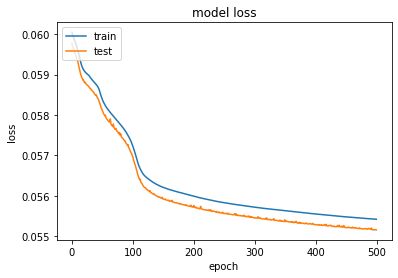

In [20]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
get_encoded_beat = Model(inputs=ae_model.input, outputs=ae_model.get_layer("CODE").output)
print(len(test_x))

5914


In [22]:
encoded_beat = get_encoded_beat.predict(test_x)
encoded_beat = encoded_beat.reshape((len(test_x),6))
encoded_beat.shape

(5914, 6)

In [23]:
reconstructed_beats = ae_model.predict(test_x)

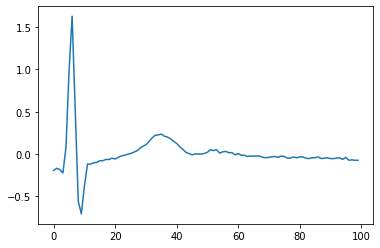

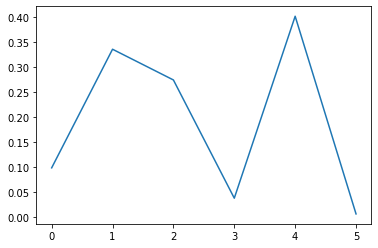

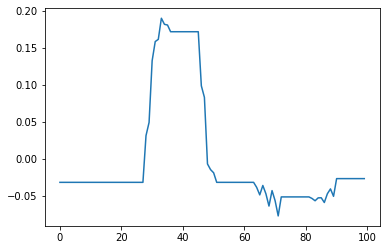

In [24]:
#original beats
test_beat = np.array(test_x)
data = test_beat[2]
plt.plot(data)
plt.show()

#encoded beats
enc_beats = np.array(encoded_beat)
data1 = enc_beats[2]
plt.plot(data1)
plt.show()

#reconstructed beats
rec_beats = np.array(reconstructed_beats)
data2 = rec_beats[2]
plt.plot(data2)
plt.show()

Original signal:  0


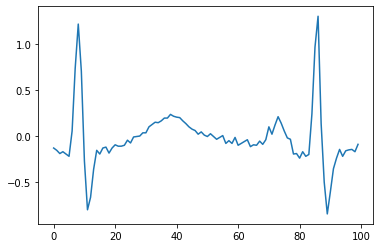

Encoded signal:  0


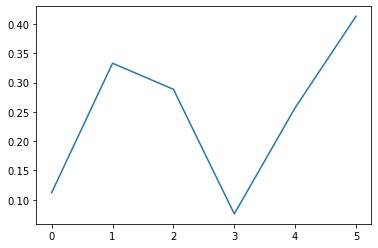

Reconstructed signal:  0


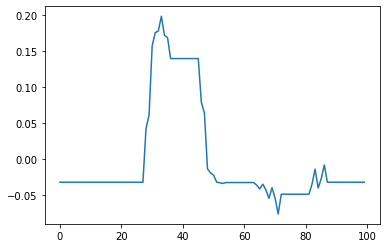

Original signal:  1


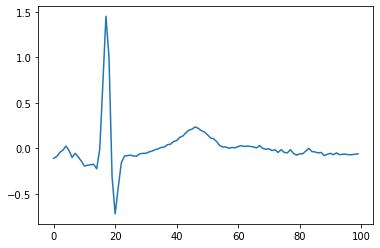

Encoded signal:  1


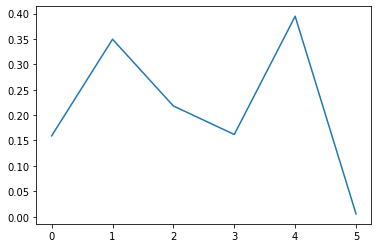

Reconstructed signal:  1


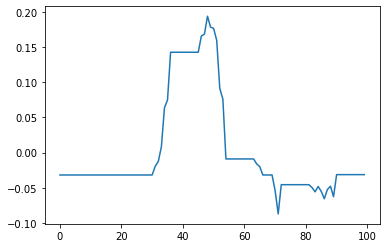

Original signal:  2


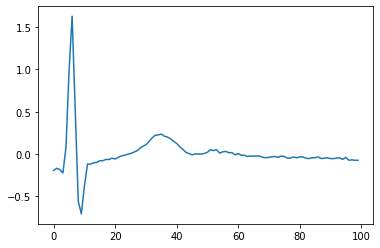

Encoded signal:  2


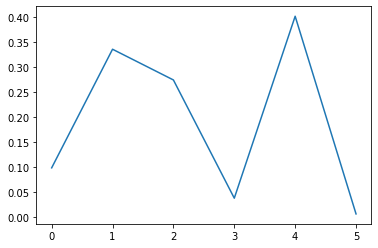

Reconstructed signal:  2


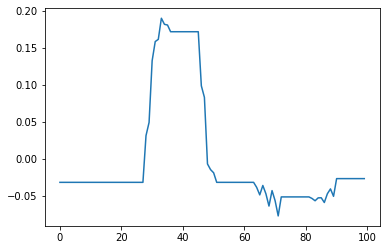

Original signal:  3


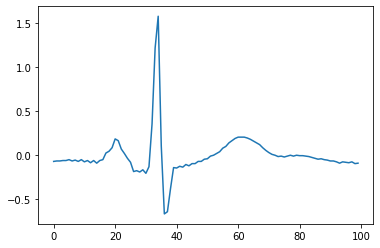

Encoded signal:  3


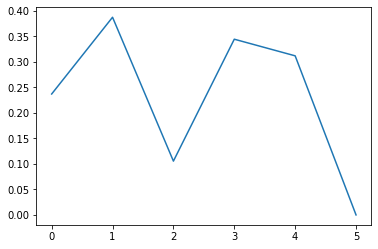

Reconstructed signal:  3


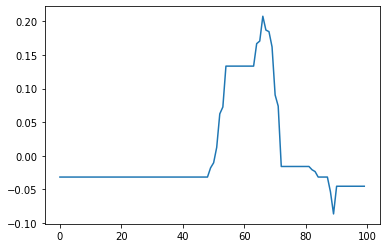

Original signal:  4


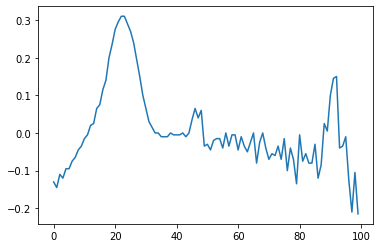

Encoded signal:  4


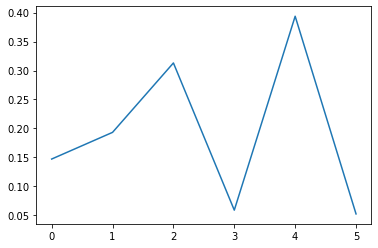

Reconstructed signal:  4


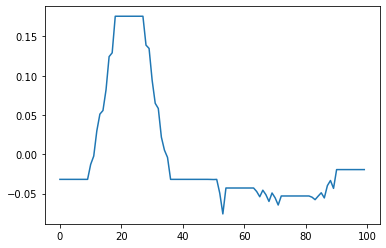

Original signal:  5


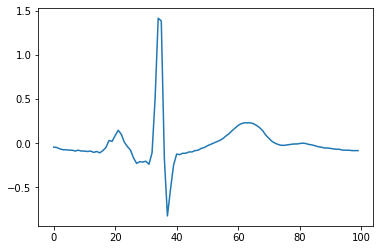

Encoded signal:  5


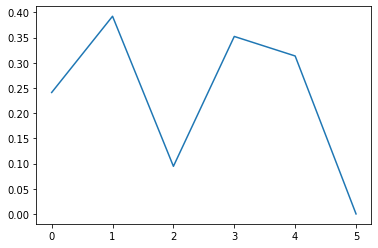

Reconstructed signal:  5


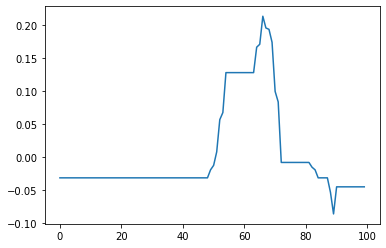

Original signal:  6


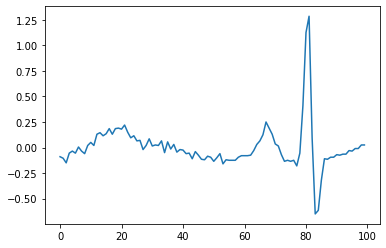

Encoded signal:  6


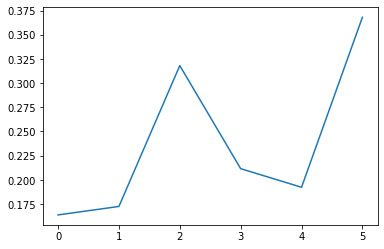

Reconstructed signal:  6


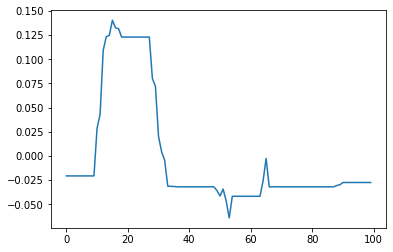

Original signal:  7


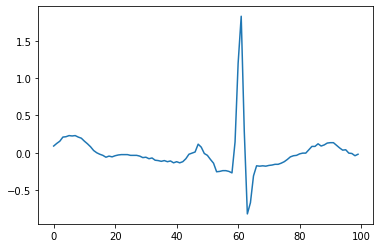

Encoded signal:  7


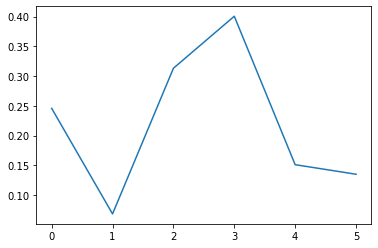

Reconstructed signal:  7


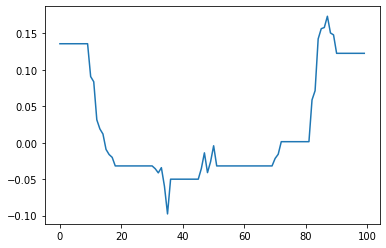

Original signal:  8


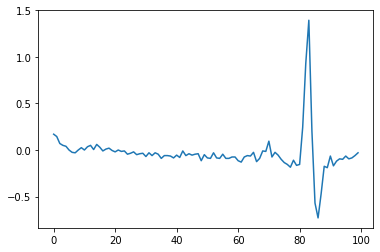

Encoded signal:  8


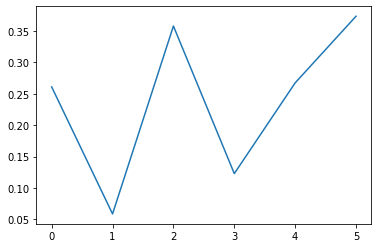

Reconstructed signal:  8


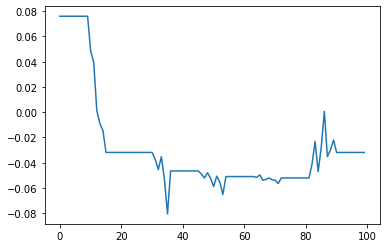

Original signal:  9


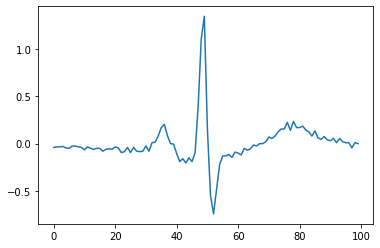

Encoded signal:  9


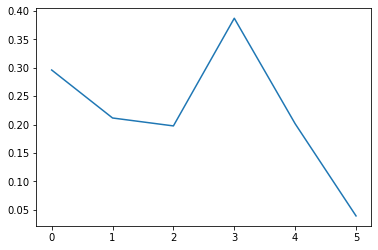

Reconstructed signal:  9


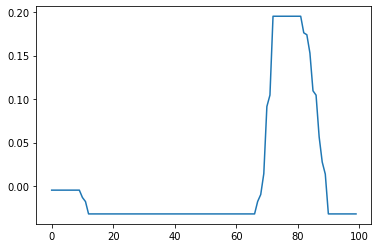

In [25]:
for i in range(10):
    print("Original signal: ",i)
    plt.plot(test_x[i])
    plt.show()
    print("Encoded signal: ",i)
    plt.plot(encoded_beat[i])
    plt.show()
    print("Reconstructed signal: ",i)
    plt.plot(reconstructed_beats[i])
    plt.show()

In [26]:
def calculate_PRD(orig_sig, reconstructed_sig):
    
    #Define a function to calculate the percentage root-mean-square difference (PRD)
    
    num = np.sum((orig_sig - reconstructed_sig)**2)
    den = np.sum(orig_sig**2)

    PRD = np.sqrt(num/den)

    return PRD

prd = calculate_PRD(test_x,reconstructed_beats)
print("PRD",calculate_PRD(test_x,reconstructed_beats))

PRD 0.9598781597941604


In [27]:
#Compression ratio
x = np.array(test_x)
original_file_size = x.size*x.itemsize

z = np.array(encoded_beat)
print(x.itemsize,z.itemsize)
print(x.size,z.size)
encoded_file_size = z.size*z.itemsize

8 4
591400 35484


In [28]:
y = np.array(reconstructed_beats)
reconstructed_file_size = y.size*y.itemsize

In [29]:
Compression_ration_wrt_encoded = original_file_size/encoded_file_size

In [30]:
print(Compression_ration_wrt_encoded)

33.333333333333336


In [42]:
def quality_score(cr, prd):
    return cr/prd

In [43]:
print(Compression_ration_wrt_encoded/prd)

34.72662961774383
